In [1]:
import pickle
from matplotlib.cbook import boxplot_stats
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
import scipy.stats 

In [48]:
%run "../../common/matrix.py"
%run "../../common/file_handler.py"
%run "../../common/plot_functions.py"
%run "../../common/svr_normalization.py"
%run "../../common/statistics.py"
%run "../../common/random_forest_reg.py"

In [3]:
METPLOT_XSIZE = 15
METPLOT_YSIZE = 8
R2PLOT_XSIZE = 10
R2PLOT_YSIZE = 7 
BOXPLOT_XSIZE = 30
BOXPLOT_YSIZE = 15
FACET_XSIZE = 20
FACET_YSIZE = 9
SUBDIST_XSIZE = 35
SUBDIST_YSIZE = 30
XGRID_PLOT = 30
YGRID_PLOT = 10

In [4]:
SAVE_FIGURE = False

#### Importing matrices one normalized and one raw.

In [6]:
matrix_raw_file = open_file_from_fullpath(ask_file_path(), 'r')
matrix_raw = pd.read_perseus(matrix_raw_file)

In [7]:
matrix_normalized_file = open_file_from_fullpath(ask_file_path(), 'r')
matrix_normalized = pd.read_perseus(matrix_normalized_file)

In [8]:
json_file = open_file_from_fullpath(ask_file_path(), 'r')

Checking if we're analysing an SVR, RF or Quantile normalized matrix

In [9]:
MATRIX_TYPE = ""

if 'svr' in get_file_name(matrix_normalized_file):
    MATRIX_TYPE = 'svr'
elif 'rf' in get_file_name(matrix_normalized_file):
    MATRIX_TYPE = 'rf'
elif 'quantile' in get_file_name(matrix_normalized_file):
    MATRIX_TYPE = 'quantile'

In [10]:
if MATRIX_TYPE != 'quantile':
	grid_file = open_file_from_fullpath(ask_file_path(), 'rb')
	grid_search = pickle.load(grid_file) #list

raw

In [11]:
matrix_qc_raw = slice_submatrix(matrix_raw, get_value_from_json(json_file, 'QC_slice'))
dictionary_qc_raw,  matrix_qc_raw = rename_matrixheader(matrix_qc_raw, get_value_from_json(json_file, 'QC_rename'))
matrix_qc_raw = sort_by_injection_order(matrix_qc_raw)

matrix_sample_raw = slice_submatrix(matrix_raw, get_value_from_json(json_file, 'sample_slice'))
dictionary_sample_raw, matrix_sample_raw = rename_matrixheader(matrix_sample_raw, get_value_from_json(json_file, 'sample_rename'))
matrix_sample_raw = sort_by_injection_order(matrix_sample_raw)

normalized

In [12]:
matrix_qc_norm = slice_submatrix(matrix_normalized, get_value_from_json(json_file, 'QC_slice'))
dictionary_qc_norm, matrix_qc_norm = rename_matrixheader(matrix_qc_norm, get_value_from_json(json_file, 'QC_rename'))
matrix_qc_norm = sort_by_injection_order(matrix_qc_norm)

matrix_sample_norm = slice_submatrix(matrix_normalized, get_value_from_json(json_file, 'sample_slice'))
dictionary_sample_norm, matrix_sample_norm = rename_matrixheader(matrix_sample_norm, get_value_from_json(json_file, 'sample_rename'))
matrix_sample_norm = sort_by_injection_order(matrix_sample_norm)

Obtain injection order and metabolites for each matrix

In [13]:
qc_raw_metabolites = cut_metabolites(matrix_qc_raw)
qc_raw_injection_order = get_injection_order_plugin(matrix_qc_raw)

sample_raw_metabolites = cut_metabolites(matrix_sample_raw)
sample_raw_injection_order = get_injection_order_plugin(matrix_sample_raw)

qc_norm_metabolites = cut_metabolites(matrix_qc_norm)
qc_norm_injection_order = get_injection_order_plugin(matrix_qc_norm)

sample_norm_metabolites = cut_metabolites(matrix_sample_norm)
sample_norm_injection_order = get_injection_order_plugin(matrix_sample_norm)

PREDICTION

In [14]:
if MATRIX_TYPE == "svr":
    qc_predicted_meta = prediction(grid_search, qc_raw_metabolites, qc_raw_injection_order)
    sample_predicted_meta = prediction(grid_search, sample_raw_metabolites, sample_raw_injection_order)
elif MATRIX_TYPE == "rf":
    qc_predicted_meta = get_prediction(grid_search, qc_raw_metabolites)
    sample_predicted_meta = get_prediction(grid_search, sample_raw_metabolites)
else:
    print('unsupported grid search!')

Plots

In [44]:
met_n = int(input('please insert metabolite number '))
if met_n > len(sample_raw_metabolites):
    print('out of metabolites range!')

### Plot of QC and samples rawdata. 
Here we can see the analytical drift of the metabolite previously chosen

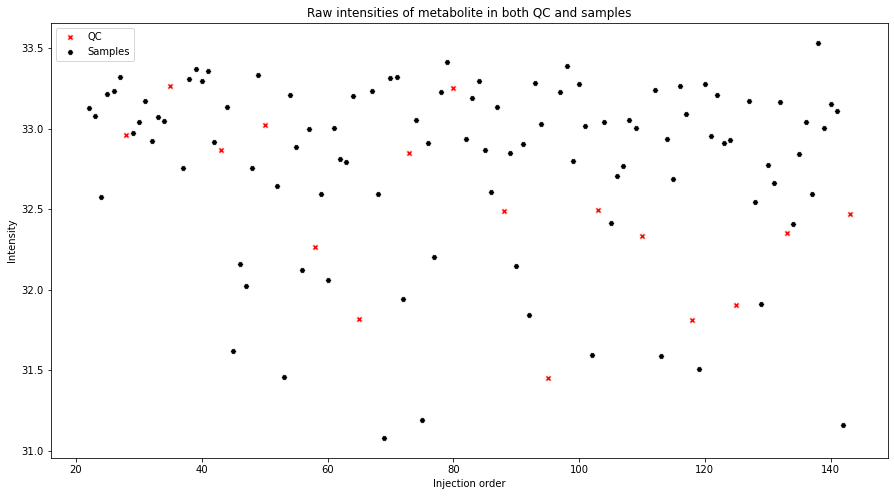

In [54]:
plot_metabolite(qc_raw_injection_order, qc_raw_metabolites[met_n], sample_raw_injection_order, sample_raw_metabolites[met_n], METPLOT_XSIZE, METPLOT_YSIZE, 'Raw intensities of metabolite in both QC and samples')

#### Plot of QC and sample metabolite without drift. 
This plot shows the ratio of the metabolite previously chosen 

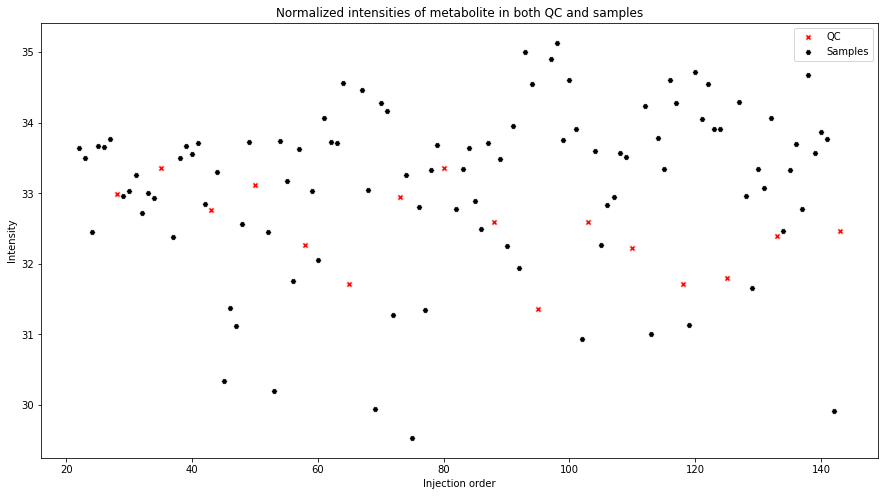

In [53]:
plot_metabolite(qc_norm_injection_order, qc_norm_metabolites[met_n], sample_norm_injection_order, sample_norm_metabolites[met_n], METPLOT_XSIZE, METPLOT_YSIZE, 'Normalized intensities of metabolite in both QC and samples')

#### Plot of QC and samples metabolite intensity
This plot shows the intensity normalized

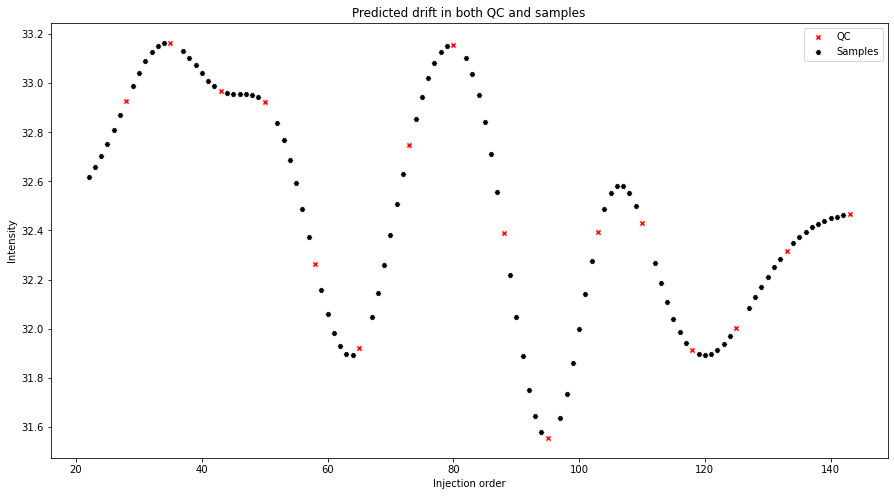

In [55]:
if MATRIX_TYPE != "quantile":
	plot_metabolite(qc_norm_injection_order, qc_predicted_meta[met_n], sample_norm_injection_order, sample_predicted_meta[met_n], METPLOT_XSIZE, METPLOT_YSIZE, 'Predicted drift in both QC and samples')

##### Most used parameters in grid search

In [ ]:
if MATRIX_TYPE != "quantile":
	plot_grid_best_parameters(get_file_name(matrix_normalized_file) + ' - Most used params in grid search', grid_search, XGRID_PLOT, YGRID_PLOT, save_fig= SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Best_grid_params','.svg'))

##### Mean and variance of each metabolites in QC

In [ ]:
variance_rawqc, mean_rawqc = get_variance_mean(qc_raw_metabolites)
variance_normqc, mean_normqc = get_variance_mean(qc_norm_metabolites)
if MATRIX_TYPE != "quantile":
	variance_predqc, mean_predqc = get_variance_mean(qc_predicted_meta)

In [ ]:
sb.distplot(qc_raw_metabolites)
if MATRIX_TYPE != "quantile":
	sb.distplot(qc_predicted_meta)

In [ ]:
total_var_qcraw = np.var(qc_raw_metabolites)
if MATRIX_TYPE != "quantile":
	total_var_qcpred = np.var(qc_predicted_meta)
total_var_qcnorm = np.var(qc_norm_metabolites)
if MATRIX_TYPE != "quantile":
	print(total_var_qcraw, total_var_qcpred, total_var_qcnorm)
else:
	print(total_var_qcraw, total_var_qcnorm)

In [ ]:
np.array(qc_raw_metabolites)

In [ ]:
plot_variance(get_file_name(matrix_raw_file) + ' Variances between qc raw and normalized ',variance_rawqc, variance_normqc, 10,10, 'var_qc_raw', 'var_qc_norm' ,color_r= 'blue', color_n= 'yellow', save_fig= SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Variance_between_qcraw_and_norm','.svg'))

In [ ]:
variance_plot(variance_normqc,50, R2PLOT_XSIZE, R2PLOT_YSIZE,title= get_file_name(matrix_normalized_file) + ' - variance qc norm', fig_save= SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Variance_qc_norm','.svg') )

In [ ]:
if MATRIX_TYPE != "quantile":
	variance_plot(variance_predqc, 50, R2PLOT_XSIZE, R2PLOT_YSIZE, title= get_file_name(matrix_normalized_file) + ' - variance qc pred', fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Variance_qc_pred','.svg') )

In [ ]:
variance_plot(variance_rawqc, 50, R2PLOT_XSIZE, R2PLOT_YSIZE, title= get_file_name(matrix_raw_file) + ' - variance qc raw', fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_raw_file), get_file_name(matrix_raw_file), '_Variance_qc_raw','.svg') )

##### R2score

In [ ]:
# for each model
if MATRIX_TYPE != "quantile":
	r2qc = get_r2_score(qc_raw_metabolites, qc_predicted_meta)
	mean_r2 = np.mean(r2qc)
	var_r2 = np.var(r2qc)

In [ ]:
if MATRIX_TYPE != "quantile":
	r2qc.shape

In [ ]:
if MATRIX_TYPE != "quantile":
	print(mean_r2, var_r2)

In [ ]:
if MATRIX_TYPE != "quantile":
	plot_r2_distribution(r2qc, BOXPLOT_XSIZE, BOXPLOT_YSIZE, get_file_name(matrix_normalized_file) + ' R2 score',fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_R2score_qcraw_pred_histoplot','.svg') )

In [ ]:
if MATRIX_TYPE != "quantile":
	r2qc_threshold = np.array(list(filter(lambda x: x > 0.5, r2qc)))
	r2qc_threshold.shape

In [ ]:
if MATRIX_TYPE != "quantile":
	plot_scatterR2(get_file_name(matrix_raw_file) ,np.array(qc_raw_metabolites).T, np.array(qc_predicted_meta).T, 'Original', 'Predicted', 10, 10 ,fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_R2score_qcraw_pred_scatter','.svg'))

MSE (mean squared error)

In [ ]:
if MATRIX_TYPE != "quantile":
	mse_qc = get_mse_score(qc_raw_metabolites, qc_predicted_meta )
	mean_mse_qc_model = np.mean(mse_qc)
	mean_mse_qc_model

In [ ]:
if MATRIX_TYPE != "quantile":
	plot_r2_distribution(mse_qc, BOXPLOT_XSIZE, BOXPLOT_YSIZE, get_file_name(matrix_normalized_file) + ' MSE score',fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_MSEscore_qcraw_pred_histoplot','.svg'))

Median absolute error

In [ ]:
if MATRIX_TYPE != "quantile":
	mae_qc = get_MedAE(qc_raw_metabolites, qc_predicted_meta)
	mean_mae_qc = np.mean(mae_qc)
	mean_mae_qc

#### Relevant

In [ ]:
matched_matrix= slice_submatrix(matrix_normalized, get_value_from_json(json_file, 'fil_column_name'))
matched_matrix = filter_matrix(matched_matrix, get_value_from_json(json_file, 'fil_column_name'), get_value_from_json(json_file, 'column_value'))

In [ ]:
#norm

qc_meta_filtered_norm = relevant_metabolite(qc_norm_metabolites, matched_matrix, get_value_from_json(json_file, 'num_rele_meta'))
sample_meta_filtered_norm = relevant_metabolite(sample_norm_metabolites, matched_matrix, get_value_from_json(json_file, 'num_rele_meta'))

#raw

qc_meta_filtered_raw = relevant_metabolite(qc_raw_metabolites, matched_matrix, get_value_from_json(json_file, 'num_rele_meta'))
sample_meta_filtered_raw = relevant_metabolite(sample_raw_metabolites, matched_matrix, get_value_from_json(json_file, 'num_rele_meta'))

In [ ]:
# raw
vect_qc_raw_filter_meta, vect_qc_filter_raw_inj_ord  = matrix_to_vector(qc_raw_injection_order, qc_meta_filtered_raw)
vect_sample_raw_filter_meta, vect_sample_filter_raw_inj_ord = matrix_to_vector(sample_raw_injection_order, sample_meta_filtered_raw)
# norm
vect_qc_norm_filter_meta, vect_qc_filter_norm_inj_ord = matrix_to_vector(qc_norm_injection_order, qc_meta_filtered_norm)
vect_sample_filter_norm_meta, vect_sample_filter_norm_inj_ord = matrix_to_vector(sample_norm_injection_order, sample_meta_filtered_norm)

In [ ]:
# predicted
if MATRIX_TYPE != "quantile":
	qc_meta_filtered_predicted = relevant_metabolite(qc_predicted_meta, matched_matrix, get_value_from_json(json_file, 'num_rele_meta'))
	sample_meta_filtered_predicted = relevant_metabolite(sample_predicted_meta, matched_matrix, get_value_from_json(json_file, 'num_rele_meta'))

In [ ]:
# predicted
if MATRIX_TYPE != "quantile":
	vect_qc_pred_filter_meta, vect_qc_filter_pred_inj_ord = matrix_to_vector(qc_raw_injection_order, qc_meta_filtered_predicted)
	vect_sample_pred_filter_meta, vect_sample_filter_pred_inj_ord = matrix_to_vector(sample_raw_injection_order, sample_meta_filtered_predicted)

##### Boxplot of rawdata, predicted and normalized data 

##### Boxplot of filter metabolites (rawdata)

In [ ]:
boxplot_qc_raw = plot_filter_meta_boxplot(vect_qc_filter_raw_inj_ord, vect_qc_raw_filter_meta, xsize= METPLOT_XSIZE, ysize= METPLOT_YSIZE, title= get_file_name(matrix_raw_file) + ' - QC raw',fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_raw_file), get_file_name(matrix_raw_file), '_Boxplot_qcraw_strip_relevatmeta','.svg'))

In [ ]:
dataframe_qc_filter_raw = pd.DataFrame(create_df_boxplot_stat(qc_meta_filtered_raw))
dataframe_qc_filter_raw['fliers']

In [ ]:
save_data(dataframe_qc_filter_raw, path=generate_new_file_path(matrix_raw_file, '_boxplot_analysis_qc_filtered_raw' + ''))

#### Boxplot of filter metabolites (predicted value)

In [ ]:
if MATRIX_TYPE != "quantile":
	plot_filter_meta_boxplot( vect_qc_filter_pred_inj_ord, vect_qc_pred_filter_meta, title=get_file_name(matrix_raw_file) + ' - QC predicted', xsize=METPLOT_XSIZE, ysize= METPLOT_YSIZE, fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Boxplot_qcpred_strip_relevatmeta','.svg'))

In [ ]:
if MATRIX_TYPE != "quantile":
	dataframe_qc_filter_pred = pd.DataFrame(create_df_boxplot_stat(qc_meta_filtered_predicted))
	dataframe_qc_filter_pred['fliers']

In [ ]:
if MATRIX_TYPE != "quantile":
	save_data(dataframe_qc_filter_pred, path=generate_new_file_path(matrix_normalized_file, '_boxplot_analysis_qc_filtered_pred' + ''))

#### Boxplot of filter metabolites (ratio values)
P.N. If the imported matrix contains intensities normalized, the plot doesn't show the ratio but the intensities normalized itself.

In [ ]:
plot_filter_meta_boxplot( vect_qc_filter_norm_inj_ord, vect_qc_norm_filter_meta, title= get_file_name(matrix_normalized_file) + ' - QC normalized', xsize= METPLOT_XSIZE, ysize= METPLOT_YSIZE ,fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Boxplot_qcnorm_strip_relevatmeta','.svg'))

In [ ]:
dataframe_qc_filtered_norm = pd.DataFrame(create_df_boxplot_stat(qc_meta_filtered_norm))
for i in range(len(dataframe_qc_filtered_norm['fliers'])):
	print(dataframe_qc_filtered_norm['fliers'][i])

In [ ]:
save_data(dataframe_qc_filtered_norm, path=generate_new_file_path(matrix_normalized_file, '_boxplot_analysis_qc_filtered_normalized' + ''))

#### Dataframes containing plots scores
P.N. normalized values depend of matrix imported

This plot shows all cohort composed by QC and samples on X axes and the raw intensity of filtered metabolites on y axes. 

In [ ]:
plot_filter_meta_boxplot( vect_sample_filter_raw_inj_ord, vect_sample_raw_filter_meta, xsize=BOXPLOT_XSIZE, ysize = BOXPLOT_YSIZE, title= get_file_name(matrix_raw_file) + ' - samples raw', fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_raw_file), get_file_name(matrix_raw_file), '_Boxplot_sampleraw_strip_relevatmeta','.svg'))

In [ ]:
get_percentile(sample_raw_injection_order, np.array(sample_meta_filtered_raw).T)

In [ ]:
dataframe_samples_filtered_raw= pd.DataFrame(create_df_boxplot_stat(sample_meta_filtered_raw))

In [ ]:
save_data(dataframe_samples_filtered_raw, path=generate_new_file_path(matrix_raw_file, '_boxplot_analysis_samples_filtered_raw' + ''))

In [ ]:
plot_filter_meta_boxplot( vect_sample_filter_norm_inj_ord, vect_sample_filter_norm_meta, xsize=BOXPLOT_XSIZE, ysize= BOXPLOT_YSIZE, title= get_file_name(matrix_normalized_file) + ' - samples normalized', fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Boxplot_samplenorm_strip_relevatmeta','.svg'))

In [ ]:
dataframe_samples_filtered_norm= pd.DataFrame(create_df_boxplot_stat(sample_meta_filtered_norm))

In [ ]:
save_data(dataframe_samples_filtered_norm, path=generate_new_file_path(matrix_normalized_file, '_boxplot_analysis_samples_filtered_norm' + ''))

Predicted vales : This plot shows all cohort composed by QC and samples on X axes and the intensity normalized of filtered metabolites on y axes. 

In [ ]:
if MATRIX_TYPE != "quantile":
	plot_filter_meta_boxplot( vect_sample_filter_pred_inj_ord, vect_sample_pred_filter_meta, xsize = BOXPLOT_XSIZE, ysize = BOXPLOT_YSIZE, title= get_file_name(matrix_raw_file) + ' - sample predicted', fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Boxplot_samplepredicted_strip_relevatmeta','.svg'))

In [ ]:
if MATRIX_TYPE != "quantile":
	dataframe_samples_filtered_predicted = pd.DataFrame(create_df_boxplot_stat(sample_meta_filtered_predicted))

In [ ]:
if MATRIX_TYPE != "quantile":
	save_data(dataframe_samples_filtered_predicted, path=generate_new_file_path(matrix_normalized_file, '_boxplot_analysis_samples_filtered_pred' + ''))

#### Facet_plot
The plots below show the filtered metabolites in different cases: raw intensity/ predicted/ ratio (or intensity normalized) are divided between QC and Samples so each plot exhibit special case. 

In [ ]:
qc_raw_facet =generate_data_facet_plot(qc_raw_injection_order, qc_meta_filtered_raw)
qc_norm_facet = generate_data_facet_plot(qc_norm_injection_order, qc_meta_filtered_norm)

sample_raw_facet = generate_data_facet_plot(sample_raw_injection_order, sample_meta_filtered_raw)
sample_norm_facet = generate_data_facet_plot(sample_norm_injection_order, sample_meta_filtered_norm)

In [ ]:
if MATRIX_TYPE != "quantile":
	qc_pred_facet = generate_data_facet_plot(qc_raw_injection_order, qc_meta_filtered_predicted)
	sample_pred_facet = generate_data_facet_plot(sample_raw_injection_order, sample_meta_filtered_predicted)

In [ ]:
qc_filt_raw_boxplot = create_facetgrid_plot(qc_raw_facet, FACET_XSIZE, FACET_YSIZE, title= get_file_name(matrix_raw_file) + ' - Intensity variation',fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_raw_file), get_file_name(matrix_raw_file), '_Boxplot_50rele_qcraw','.svg'))

In [ ]:
df_qcraw_inmeta = pd.DataFrame(boxplot_stats(np.array(qc_meta_filtered_raw).T))

In [ ]:

save_data(df_qcraw_inmeta, path=generate_new_file_path(matrix_raw_file, '_boxplot_analysis_metaqc_filtered_raw' + ''))

In [ ]:
create_facetgrid_plot(qc_norm_facet, FACET_XSIZE, FACET_YSIZE, title= get_file_name(matrix_normalized_file) + ' - Intensity variation', fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Boxplot_50rele_qcnorm','.svg'))

In [ ]:
df_qcnorm_inmeta = pd.DataFrame(boxplot_stats(np.array(qc_meta_filtered_norm).T))

In [ ]:
save_data(df_qcnorm_inmeta, path=generate_new_file_path(matrix_normalized_file, '_boxplot_analysis_qcmeta_filtered_norm' + ''))

In [ ]:
if MATRIX_TYPE != "quantile":
	create_facetgrid_plot(qc_pred_facet, FACET_XSIZE, FACET_YSIZE, title= get_file_name(matrix_raw_file) + ' - Intensity variation (predicted)', fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Boxplot_50rele_qcpred','.svg'))

In [ ]:
if MATRIX_TYPE != "quantile":
	df_qcpred_inmeta= pd.DataFrame(boxplot_stats(np.array(qc_meta_filtered_predicted).T))

In [ ]:
if MATRIX_TYPE != "quantile":
	save_data(df_qcpred_inmeta, path=generate_new_file_path(matrix_normalized_file, '_boxplot_analysis_qcmeta_filtered_pred' + ''))

In [ ]:
create_facetgrid_plot(sample_raw_facet, FACET_XSIZE, FACET_YSIZE, title= get_file_name(matrix_raw_file) + ' - Intensity variation in samples', fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_raw_file), get_file_name(matrix_raw_file), '_Boxplot_50rele_sampleraw','.svg'))

In [ ]:
df_sampleraw_in_meta = pd.DataFrame(boxplot_stats(np.array(sample_meta_filtered_raw).T))

In [ ]:
save_data(df_sampleraw_in_meta, path=generate_new_file_path(matrix_raw_file, '_boxplot_analysis_samplesmeta_filtered_raw' + ''))

In [ ]:
create_facetgrid_plot(sample_norm_facet, FACET_XSIZE, FACET_YSIZE, title= get_file_name(matrix_normalized_file) + ' - Intensity variation in samples',fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Boxplot_50rele_samplesnorm','.svg'))

In [ ]:
df_samplenorm_inmeta= pd.DataFrame(boxplot_stats(np.array(sample_meta_filtered_norm).T))

In [ ]:

save_data(df_samplenorm_inmeta, path=generate_new_file_path(matrix_normalized_file, '_boxplot_analysis_samplemeta_filtered_normalized' + ''))

In [ ]:
if MATRIX_TYPE != "quantile":
	create_facetgrid_plot(sample_pred_facet, FACET_XSIZE, FACET_YSIZE, title= get_file_name(matrix_raw_file) + ' - Intensity variation in samples (predicted)',fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Boxplot_50rele_samplepred','.svg'))

In [ ]:
if MATRIX_TYPE != "quantile":
	df_samplepred_inmeta= pd.DataFrame(boxplot_stats(np.array(sample_meta_filtered_predicted).T))

In [ ]:
if MATRIX_TYPE != "quantile":
	save_data(df_samplepred_inmeta, path=generate_new_file_path(matrix_normalized_file, '_boxplot_analysis_samplemeta_filtered_predicted' + ''))

R2 score

In [ ]:
variance_fil_rawqc, mean_fil_rawqc = get_variance_mean(qc_meta_filtered_raw)
variance_fil_normqc, mean_fil_normqc = get_variance_mean(qc_meta_filtered_norm)

In [ ]:
plot_variance(get_file_name(matrix_raw_file) + ' - Variance between QC raw and normalized (filtered metabolites)', variance_fil_rawqc, variance_fil_normqc, 10,10, 'var_fil_qc_raw', 'var_fil_qc_norm' ,color_r= 'blue', color_n= 'red', alpha_n= .6, bin = 70,save_fig= SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Variance_between_filter_qcraw_and_norm','.svg') )

In [ ]:
total_var_fil_qcraw = np.var(qc_meta_filtered_raw)
total_var_fil_qcnorm = np.var(qc_meta_filtered_norm)
if MATRIX_TYPE != "quantile":
	total_var_fil_qcpred = np.var(qc_meta_filtered_predicted)
if MATRIX_TYPE != "quantile":
	print(total_var_fil_qcraw, total_var_fil_qcnorm, total_var_fil_qcpred)
else:
	print(total_var_fil_qcraw, total_var_fil_qcnorm)

In [ ]:
if MATRIX_TYPE != "quantile":
	r2_filqc = get_r2_score(qc_meta_filtered_raw, qc_meta_filtered_predicted)
	r2_filqc

In [ ]:
if MATRIX_TYPE != "quantile":
	variance_r2_filqc = np.var(r2_filqc)
	mean_r2_filqc = np.mean(r2_filqc)
	print(variance_r2_filqc, mean_r2_filqc)

In [ ]:
if MATRIX_TYPE != "quantile":
	plot_r2_distribution(r2_filqc, BOXPLOT_XSIZE, BOXPLOT_YSIZE, title= get_file_name(matrix_raw_file) + ' - R2score relevant metabolites',fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_R2score_relevant_qcraw_pred_histoplot','.svg'))

In [ ]:
if MATRIX_TYPE != "quantile":
	plot_scatterR2(get_file_name(matrix_raw_file) + ' - relevant metabolites - ', np.array(qc_meta_filtered_raw).T, np.array(qc_meta_filtered_predicted).T, 'Original', 'Predicted', 10, 10, fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_R2score_relevant_qcraw_pred_scatter','.svg'))

##### Based on filtered metabolites, these plots show the batch experiment without analytical drift.

### Raw

In [ ]:
subplots_filtered_meta_nodrift(get_file_name(matrix_raw_file) + ' raw relevant metabolites ',qc_raw_injection_order, qc_meta_filtered_raw, sample_raw_injection_order, sample_meta_filtered_raw, 10, 50, BOXPLOT_XSIZE, BOXPLOT_YSIZE,fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_raw_file), get_file_name(matrix_raw_file), '_subplots_raw_relevant_metabolites','.svg'))

#### Ratio
For intensities case change y-axis scale.

In [ ]:
subplots_filtered_meta_nodrift(get_file_name(matrix_normalized_file) + ' - relevant metabolites', qc_raw_injection_order, qc_meta_filtered_norm, sample_norm_injection_order, sample_meta_filtered_norm, -3, 50, BOXPLOT_XSIZE, BOXPLOT_YSIZE,fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Subplots_relevat_metabolites_normalized','.svg'))

Drift predicted

In [ ]:
if MATRIX_TYPE != "quantile":
	subplots_filtered_meta_nodrift(get_file_name(matrix_raw_file) + ' predicted relevant metabolites ', qc_raw_injection_order, qc_meta_filtered_predicted, sample_norm_injection_order, sample_meta_filtered_predicted, 10, 40, BOXPLOT_XSIZE, BOXPLOT_YSIZE,fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Subplots_relevant_metabolites_predicted','.svg'))

#### Distribution subplot

In [ ]:
distr = prepare_data_to_gaussian_distribution(qc_meta_filtered_norm, sample_meta_filtered_norm, qc_raw_injection_order, sample_norm_injection_order)

In [ ]:
subplots_gaussian_distribution(distr, get_file_name(matrix_normalized_file) + ' - Distribution of filtered metabolites', SUBDIST_XSIZE, SUBDIST_YSIZE,fig_save=SAVE_FIGURE, fig_path= merge_path_filename(get_file_path(matrix_normalized_file), get_file_name(matrix_normalized_file), '_Distribution_relevant_metabolites','.svg'))

In [ ]:
matrix_normalized_file.close()
matrix_raw_file.close()

json_file.close()